<a href="https://colab.research.google.com/github/SCS-Technology-and-Innovation/DACS/blob/main/DTDA/compromise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Picking the best option
## Multiobjective compromising

Often, decision making involves two or more possibly contradictory criteria to simultaneously optimize. Picking the best in the sense of one criterion tends to imply a sacrifice in another. In this session, we will explore how to deal with these types of situations.

As an example scenario, let's assume we have been looking to buy a used car. We have a bunch of options for which we have quantified the criteria we wish to take into account.

In [1]:
def normalize(d): # a trick we need later to make numerical sense of things
  low = min(d)
  high = max(d)
  span = high - low
  return [ (value - low) / span for value in d]

In [2]:
n = 200 # how many alternatives to generate

import pandas as pd
from random import randint

# assign a price to each car in CAD
p = [ randint(3500, 35000) for car in range(n) ]
price = pd.Series(p, name = 'Price')
nprice = pd.Series(normalize(p), name = 'NPrice')

# assign a milage
m = [ randint(200, 150000) for car in range(n) ]
milage = pd.Series(m, name = 'Milage')
nmilage = pd.Series(normalize(m), name = 'NMilage')

# assign how many miles per gallon the car runs on average
m2 = [ randint(30, 70) for car in range(n) ]
mpg = pd.Series(m2, name = 'FuelEfficiency')
nmpg = pd.Series(normalize(m2), name = 'NFuelEfficiency')

# assign carbon dioxide emissions per gallon in grams
e = [ randint(8000, 9000) for car in range(n) ]
co2 = pd.Series(e, name = 'Emissions')
nco2 = pd.Series(normalize(e), name = 'NEmissions')

# subjective coolness on scale from 1 (lame) to 5 (neat)
c = [ randint(1, 5) for car in range(n) ]
cool = pd.Series(c, name = 'Rating')
ncool = pd.Series(normalize(c), name = 'NRating')

We can combine all this information into a **data frame**, a spreadsheet of sorts. To do so, we concatenate the lists as columns. We can look at the "head" (the first few rows) of the result to see what we have created.

In [3]:
attributes = [ price, milage, mpg, co2, cool, nprice, nmilage, nmpg, nco2, ncool ]
cars = pd.concat(attributes, axis = 1)
cars.head()

,Price,Milage,FuelEfficiency,Emissions,Rating,NPrice,NMilage,NFuelEfficiency,NEmissions,NRating
0,29125,63377,45,8156,2,0.814959,0.420777,0.375,0.156784,0.25
1,6329,145436,33,8182,5,0.088185,0.970027,0.075,0.182915,1.00
2,21868,62374,51,8512,2,0.583594,0.414064,0.525,0.514573,0.25
3,20573,105255,42,8872,2,0.542307,0.701082,0.300,0.876382,0.25
4,15169,14466,56,8965,2,0.370018,0.093399,0.650,0.969849,0.25


We can now easily ask questions like "which car is the cheapest?".

In [4]:
cheapest = cars['Price'].idxmin() # what is the index (row label) of the row that has the minimum value of column Price
print(cheapest) # the index
cars.loc[cheapest] # the data on the row corresponding to that index

69


Price                3563.000000
Milage             132239.000000
FuelEfficiency         38.000000
Emissions            8353.000000
Rating                  4.000000
NPrice                  0.000000
NMilage                 0.881695
NFuelEfficiency         0.200000
NEmissions              0.354774
NRating                 0.750000
Name: 69, dtype: float64

Or "which ones are the five-star rated alternatives in terms of how cool I think they are?".

In [5]:
cars['Rating'] == 5

0      False
1       True
2      False
3      False
4      False
       ...  
195    False
196    False
197    False
198    False
199    False
Name: Rating, Length: 200, dtype: bool

In [6]:
cars.loc[ cars['Rating'] == 5 ]

,Price,Milage,FuelEfficiency,Emissions,Rating,NPrice,NMilage,NFuelEfficiency,NEmissions,NRating
1,6329,145436,33,8182,5,0.088185,0.970027,0.075,0.182915,1.0
7,19698,64663,56,8963,5,0.514411,0.429385,0.650,0.967839,1.0
9,13108,9572,66,8107,5,0.304310,0.060642,0.900,0.107538,1.0
16,8673,123372,47,8951,5,0.162915,0.822345,0.425,0.955779,1.0
20,30491,15062,32,8437,5,0.858509,0.097388,0.050,0.439196,1.0
22,20394,57071,64,8785,5,0.536600,0.378569,0.850,0.788945,1.0
24,8097,52884,41,8035,5,0.144551,0.350544,0.275,0.035176,1.0
25,26870,30513,63,8343,5,0.743066,0.200807,0.825,0.344724,1.0
27,29231,20377,70,8283,5,0.818338,0.132963,1.000,0.284422,1.0
39,11180,43406,33,8114,5,0.242843,0.287105,0.075,0.114573,1.0


Which ones are both cool and cost less than 10k?

In [7]:
cars[ (cars['Rating'] == 5) & (cars['Price'] < 10000) ]

,Price,Milage,FuelEfficiency,Emissions,Rating,NPrice,NMilage,NFuelEfficiency,NEmissions,NRating
1,6329,145436,33,8182,5,0.088185,0.970027,0.075,0.182915,1.0
16,8673,123372,47,8951,5,0.162915,0.822345,0.425,0.955779,1.0
24,8097,52884,41,8035,5,0.144551,0.350544,0.275,0.035176,1.0
83,9697,81866,67,8668,5,0.195562,0.544531,0.925,0.671357,1.0
87,8145,93729,42,8493,5,0.146082,0.623934,0.300,0.495477,1.0
104,8787,30349,41,8107,5,0.166550,0.199710,0.275,0.107538,1.0
131,7228,37550,52,8552,5,0.116846,0.247908,0.550,0.554774,1.0


Our next difficulty lies in that we want to **maximize** some of these criteria, while we wish to **minimize** others. It is easier to automate the processing if all criteria "work the same way".

Luckily, math solves this. If we multiply a function by -1, it's hills become its valleys and vice versa. To understand this better, let's improvise a function that has nothing to do with anything, just to see what happens when we multiply it by -1.

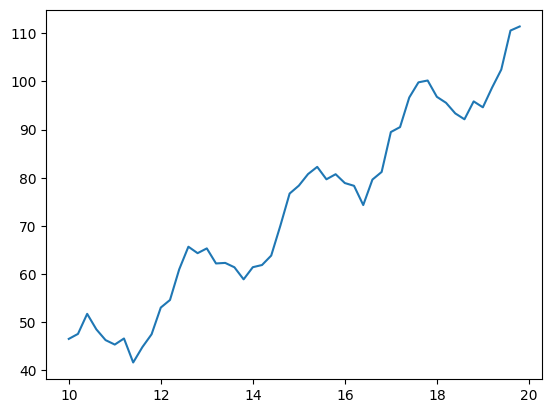

In [8]:
import numpy as np
x = np.arange(10, 20, 0.2)
r = np.random.rand(x.size)
y = 6.5 * np.sin(34 * x) + 1.8 * x**1.4 - 0.6 * x + 5 * r
import matplotlib.pyplot as plt
plt.plot(x, y)
plt.show()

Now, we keep the same x but use -y instead.

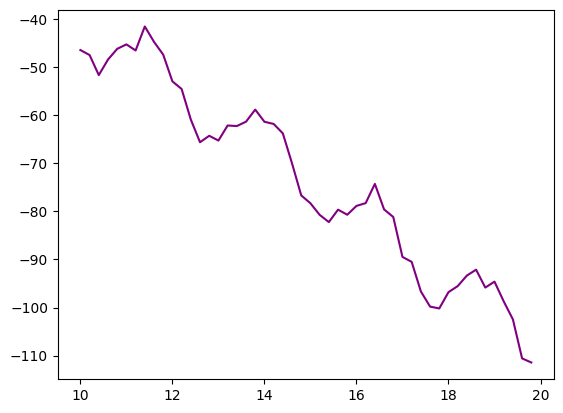

In [9]:
plt.plot(x, -y, c = 'purple')
plt.show()

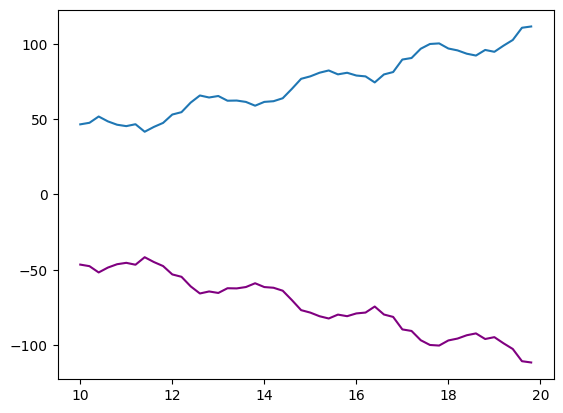

In [10]:
plt.plot(x, y)
plt.plot(x, -y, c = 'purple')
plt.show()

In [11]:
ideal = {
  'Price' : 1, # minimize
  'Milage' : 1, # also minimize
  'FuelEfficiency' : -1, # maximize (minimize the negative)
  'Emissions' : 1, # minimize again
  'Rating' : -1, # maximize
  'NPrice' : 1, # minimize
  'NMilage' : 1, # also minimize
  'NFuelEfficiency' : -1, # maximize (minimize the negative)
  'NEmissions' : 1, # minimize again
  'NRating' : -1 # maximize
}

multipliers = [ ideal[c] for c in cars.columns ]
multipliers

[1, 1, -1, 1, -1, 1, 1, -1, 1, -1]

In [12]:
def dominates(challenger, challenged): # smaller is better
  if all(v <= w for v, w in zip(challenger, challenged)): # if all aspects are at least as good
    return any( v < w for v, w in zip(challenger, challenged)) # and at least one is actually better
  return False


x = [ 1, 2, 3 ]
y = [ 0, 1, 2 ]
z = [ 1, 4, 3 ]

print('x vs. y', dominates(x, y))
print('y vs. x', dominates(y, x))
print('x vs. z', dominates(x, z))
print('z vs. x', dominates(z, x))
print('z vs. y', dominates(z, y))
print('y vs. z', dominates(y, z))

x vs. y False
y vs. x True
x vs. z True
z vs. x False
z vs. y False
y vs. z True


In [13]:
nondominated = set()

for i, data in cars.iterrows():
  car = [ m * v for m, v in zip(multipliers, data) ]
  discard = False # assume it to be invincible
  for j in range(i + 1, n): # check all the other cars
    otherData = cars.iloc[j] # get their data
    alt = [ m * v for m, v in zip(multipliers, otherData) ]
    if dominates(alt, car): # challenge the car with the alternative
      discard = True # we will not want to consider the loser
      break # no need to check further, it was already beaten
  if not discard: # nothing beat it
    nondominated.add(i) # remember the row

len(nondominated)

112

In [14]:
keep = sorted(list(nondominated))
candidates = cars.iloc[keep]
candidates

,Price,Milage,FuelEfficiency,Emissions,Rating,NPrice,NMilage,NFuelEfficiency,NEmissions,NRating
1,6329,145436,33,8182,5,0.088185,0.970027,0.075,0.182915,1.00
5,7731,13253,58,8424,1,0.132883,0.085280,0.700,0.426131,0.00
9,13108,9572,66,8107,5,0.304310,0.060642,0.900,0.107538,1.00
14,7294,27208,41,8822,2,0.118950,0.178686,0.275,0.826131,0.25
18,6483,61569,63,8116,3,0.093094,0.408676,0.825,0.116583,0.50
...,...,...,...,...,...,...,...,...,...,...
195,30426,89300,40,8311,2,0.856437,0.594289,0.250,0.312563,0.25
196,8585,99665,52,8943,3,0.160110,0.663666,0.550,0.947739,0.50
197,9871,113697,70,8800,1,0.201109,0.757587,1.000,0.804020,0.00
198,24926,81854,60,8774,4,0.681088,0.544451,0.750,0.777889,0.75


In [15]:
candidates.loc[candidates['Price'].idxmin()]

Price                3563.000000
Milage             132239.000000
FuelEfficiency         38.000000
Emissions            8353.000000
Rating                  4.000000
NPrice                  0.000000
NMilage                 0.881695
NFuelEfficiency         0.200000
NEmissions              0.354774
NRating                 0.750000
Name: 69, dtype: float64

In [16]:
candidates.loc[candidates['Price'].idxmax()]

Price              34769.000000
Milage             46560.000000
FuelEfficiency        59.000000
Emissions           8564.000000
Rating                 4.000000
NPrice                 0.994899
NMilage                0.308215
NFuelEfficiency        0.725000
NEmissions             0.566834
NRating                0.750000
Name: 183, dtype: float64

In [17]:
budget = 12000
stars = 3
consider = candidates[ (candidates['Rating'] >= stars) & (candidates['Price'] <= budget) ]
consider

,Price,Milage,FuelEfficiency,Emissions,Rating,NPrice,NMilage,NFuelEfficiency,NEmissions,NRating
1,6329,145436,33,8182,5,0.088185,0.970027,0.075,0.182915,1.00
18,6483,61569,63,8116,3,0.093094,0.408676,0.825,0.116583,0.50
23,10247,105566,60,8539,3,0.213097,0.703163,0.750,0.541709,0.50
24,8097,52884,41,8035,5,0.144551,0.350544,0.275,0.035176,1.00
26,5124,148151,56,8747,3,0.049767,0.988200,0.650,0.750754,0.50
34,7901,119538,68,8760,3,0.138303,0.796683,0.950,0.763819,0.50
35,6051,80071,46,8171,3,0.079322,0.532516,0.400,0.171859,0.50
37,8927,75099,47,8097,4,0.171013,0.499237,0.425,0.097487,0.75
48,5797,47829,57,8714,3,0.071224,0.316709,0.675,0.717588,0.50
59,10135,29244,43,8777,4,0.209526,0.192313,0.325,0.780905,0.75


In [18]:
importance = { 'NMilage': 0.30, 'NFuelEfficiency': 0.30, 'NEmissions': 0.15, 'NRating': 0.1, 'NPrice': 0.15 }
sum(importance.values())

1.0

In [19]:
attr = ideal.keys()
factor = [ importance.get(a, 0) * ideal[a] for a in attr ] # all of the other columns will have zero weight
factor

[0, 0, 0, 0, 0, 0.15, 0.3, -0.3, 0.15, -0.1]

In [20]:
compromise = []
for i, data in consider.iterrows():
  combo = sum( [ f * d for f, d in zip(factor, data) ])
  compromise.append(combo)

cand = consider.copy()
l = 'Combination'
cand[l] = compromise
inOrder = cand.sort_values(by = [l])
inOrder.head(10) # top ten in terms of the lowest (best) combination score

,Price,Milage,FuelEfficiency,Emissions,Rating,NPrice,NMilage,NFuelEfficiency,NEmissions,NRating,Combination
107,4421,1776,66,8882,3,0.027354,0.008460,0.900,0.886432,0.50,-0.180394
79,10564,5067,68,8950,3,0.223203,0.030488,0.950,0.954774,0.50,-0.149157
18,6483,61569,63,8116,3,0.093094,0.408676,0.825,0.116583,0.50,-0.143446
181,10272,58019,64,8261,3,0.213894,0.384915,0.850,0.262312,0.50,-0.118095
131,7228,37550,52,8552,5,0.116846,0.247908,0.550,0.554774,1.00,-0.089884
83,9697,81866,67,8668,5,0.195562,0.544531,0.925,0.671357,1.00,-0.084103
104,8787,30349,41,8107,5,0.166550,0.199710,0.275,0.107538,1.00,-0.081474
24,8097,52884,41,8035,5,0.144551,0.350544,0.275,0.035176,1.00,-0.050378
48,5797,47829,57,8714,3,0.071224,0.316709,0.675,0.717588,0.50,-0.039165
37,8927,75099,47,8097,4,0.171013,0.499237,0.425,0.097487,0.75,-0.012454


In [21]:
vars = ['Milage', 'FuelEfficiency', 'Emissions']
threedim = cand[vars]
threedim.head()

,Milage,FuelEfficiency,Emissions
1,145436,33,8182
18,61569,63,8116
23,105566,60,8539
24,52884,41,8035
26,148151,56,8747


In [22]:
import numpy as np

idx = threedim.index
cols = threedim.columns
matrix = np.array([ [ threedim[c][i] for c in cols ] for i in idx ])
print(matrix[:5])

[[145436     33   8182]
 [ 61569     63   8116]
 [105566     60   8539]
 [ 52884     41   8035]
 [148151     56   8747]]


In [23]:
x = matrix[:, 0]
y = matrix[:, 1]
z = matrix[:, 2]

x[:5]

array([145436,  61569, 105566,  52884, 148151])

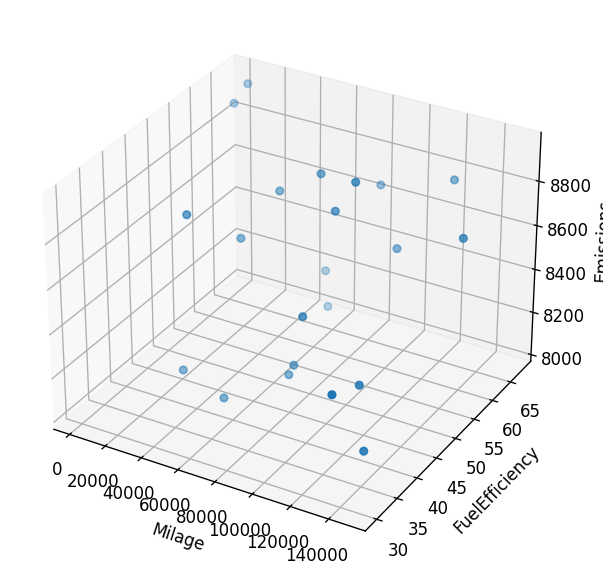

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize = (8, 6), dpi =  120)
a = fig.add_subplot(projection = '3d')
a.scatter(x, y, z, marker = 'o')
a.set_xlabel(vars[0])
a.set_ylabel(vars[1])
a.set_zlabel(vars[2])
plt.show()

In [25]:
stars = dict()
for quantity in [3, 4, 5]: # we already filtered out 1 and 2
  stars[quantity] = cand.loc[ cand['Rating'] == quantity ]

marker = {
  5 : '*', # use a star for 5
  4 : 'P', # use a thick plus for 4
  3 : 'd' # use a thin diamond for 3
}

for q in stars:
  print(q, len(stars[q]), marker[q])

3 12 d
4 4 P
5 6 *


In [29]:
data = dict()

for q in stars:
  subset = cand.loc[ cand['Rating'] == q ] # match the stars
  td = subset[vars] # get the three axis values
  M = np.array([ [ td[c][i] for c in td.columns ] for i in td.index ])
  color = subset['Price'].tolist()
  data[q] = (M, color)

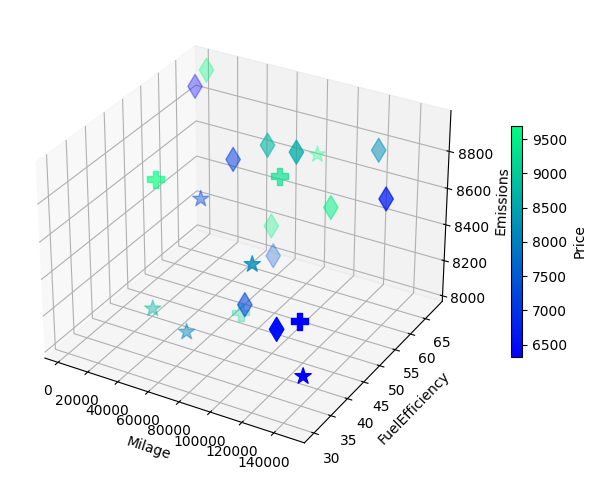

In [30]:
fig = plt.figure(1, figsize = (10, 6), dpi =  100)
a = fig.add_subplot(projection = '3d')
for q in stars:
  m, color = data[q]
  x = m[:, 0]
  y = m[:, 1]
  z = m[:, 2]
  plot = a.scatter(x, y, z, marker = marker[q], c = color, cmap = plt.cm.winter, s = 150)
a.set_xlabel(vars[0])
a.set_ylabel(vars[1])
a.set_zlabel(vars[2])
legend = fig.colorbar(plot, orientation = 'vertical', shrink = 0.5)
legend.set_label('Price')
plt.show()

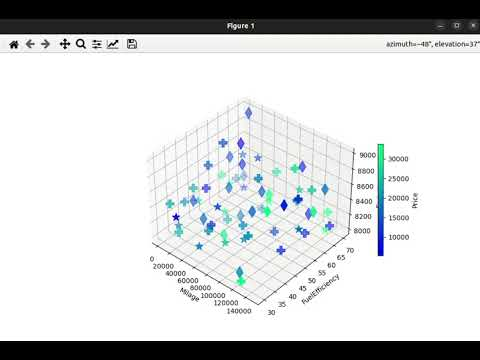

In [28]:
from IPython.display import YouTubeVideo
YouTubeVideo('c-vNm6lgeRQ')